# CNN example

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import random

import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    for kgpu in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[kgpu], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

2023-05-26 18:17:02.868544: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 18:17:02.948491: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 18:17:02.949921: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 18:17:04.241559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]


## Build data pipeline

### input and output variable list
- Note that ptend_t and ptend_q0001 are not in the output (mlo) netcdf files, but calculated real-time on a tf Dataset object.
- Variable list: https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0

In [2]:
# in/out variable lists
cfg = dict()
cfg['vars_mli'] = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
cfg['vars_mlo'] = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

## Define tf dataset
- ref: https://www.noahbrenowitz.com/post/loading_netcdfs/
- ref: https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [3]:
class E3SMDataset(object):
    def __init__(self, cfg, verbose=False):
        '''
        '''
        self.cfg = cfg

        # Initialize normalization
        self.mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
        self.mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
        self.mli_max = xr.open_dataset('./norm_factors/mli_max.nc')
        self.mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')

        # Init in/out variable list
        self.vars_mli = cfg['vars_mli']
        self.vars_mlo = cfg['vars_mlo']

        # Used to define in- output shape
        self.in_out_shape = self.cfg['in_out_shape']
        
    def flatten_layers_and_vars_1d(self, ds, dso):
        '''
        Concatenates all variables into (batch,124) and (batch,128) vectors. Used for FCNN input
        '''
        # stack
        #ds = ds.stack({'batch':{'sample','ncol'}})
        ds = ds.stack({'batch':{'ncol'}})
        ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
        #dso = dso.stack({'batch':{'sample','ncol'}})
        dso = dso.stack({'batch':{'ncol'}})
        dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')
        return ds, dso
        
    def pad_and_stack_layers_and_vars_1d(self, ds, dso):
        '''
        Pads and stack all variables into (batch, n_vertical_levels, n_variables), 
        e.g., input: (batch, 60, 6) and output: (batch, 60, 10)
        Args:
            ds xarray.Dataset(lev, ncol) with vars_mli of shapes (lev, ncol) and (ncol)
            dso xarray.Dataset(lev, ncol) with vars_mlo of shapes (lev, ncol) and (ncol)
        Returns:
            arr xarray.DataArray(batch, lev, variable)
            arro xarray.DataArray(batch, lev, variable)
        '''
        ds = ds.stack({'batch':{'ncol'}})
        (ds,) = xr.broadcast(ds) # repeat global variables across levels
        arr = ds.to_array('mlvar', name='mli')
        arr = arr.transpose('batch', 'lev', 'mlvar') 

        dso = dso.stack({'batch':{'ncol'}})
        (dso,) = xr.broadcast(dso)
        arro = dso.to_array('mlvar', name='mlo')
        arro = arro.transpose('batch', 'lev', 'mlvar')

        return arr, arro

    def load_nc_dir_with_generator(self, filelist:list):
        '''
        Return tf.dataset        
        '''
        # Define in and output shape
        self.ncol = xr.open_dataset(f_mli[0], engine='netcdf4').dims['ncol']
        self.lev = xr.open_dataset(f_mli[0], engine='netcdf4').dims['lev']
        if self.cfg['in_out_shape'] == 'pad_and_stack_layers_and_vars_1d':
            self.in_shape = (None, self.lev, len(self.vars_mli))
            self.out_shape = (None, self.lev, len(self.vars_mlo))
        else:
            self.in_shape = (None,124)
            self.out_shape = (None,128)

        # Create generator function
        def gen():
            for file in filelist:
                # read mli
                ds = xr.open_dataset(file, engine='netcdf4')
                ds = ds[self.vars_mli]
                
                # read mlo
                dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')
                
                # make mlo variales: ptend_t and ptend_q0001
                dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
                dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
                dso = dso[self.vars_mlo]
                
                # normalization, scaling
                ds = (ds-self.mli_mean)/(self.mli_max-self.mli_min)
                dso = dso*self.mlo_scale
    
                # stack
                if self.cfg['in_out_shape'] == 'pad_and_stack_layers_and_vars_1d':
                    ds, dso = self.pad_and_stack_layers_and_vars_1d(ds, dso)
                else:
                    ds, dso = self.flatten_layers_and_vars_1d(ds, dso)

                yield (ds.values, dso.values)
    
        return tf.data.Dataset.from_generator(
            gen,
            output_types=(tf.float64, tf.float64),
            output_shapes=(self.in_shape,self.out_shape)
        )

# e3smdataset = E3SMDataset(cfg)

## Instantiate tf.data.Dataset object here
- Dataset file size and dimensions: https://docs.google.com/document/d/1HgfZZJM0SygjWvSAJ5kSfql9aXUFkvLybL36p-vmdZc/edit

#### Get list of train, val filenames

In [4]:
from pathlib import Path
def get_filenames(dataroot, filenames, stride_sample=1):
    '''
    Create list of filenames
    
    Args:
        dataroot: Relative or global path to directory of filenames
        filenames: List of filename wildcards
        stride_sample int: pick every nth sample
    '''
    dataroot = Path(dataroot)
    
    filepaths = []
    for filename in filenames:
        filepaths.extend(glob.glob(str(cfg['dataroot']/Path(filename))))
    # f_mli = sorted([*f_mli1, *f_mli2]) # I commented this out. It seems unecessary to sort the list if it will be shuffled
    random.shuffle(filepaths)
    filepaths = filepaths[::stride_sample]
    # f_mli = f_mli[0:72*5] # debugging
    # random.shuffle(f_mli) # I commented this out. It seems unnecessary to shuffle twice.

    return filepaths

In [5]:
cfg['stride_sample'] = 1 # every nth sample
cfg['dataroot'] = Path('data/micro_sample/')

# todo - ritwik: make sure correct train/val/test split is used.
cfg['filenames_train'] = ['E3SM-MMF.mli.000[1234567]-*-*-*.nc', 'E3SM-MMF.mli.0008-01-*-*.nc']
cfg['filenames_val'] = ['E3SM-MMF.mli.0008-0[23456789]-*-*.nc', 'E3SM-MMF.mli.0008-1[012]-*-*.nc', 'E3SM-MMF.mli.0009-01-*-*.nc']

f_mli = get_filenames(cfg['dataroot'], cfg['filenames_train'], stride_sample=1)
f_mli_val = get_filenames(cfg['dataroot'], cfg['filenames_val'], stride_sample=1)

#### instantiate train, val loader

In [6]:
# Define in-out-shape depending on which model is used:
# cfg['in_out_shape'] = 'flatten_layers_and_vars_1d' # use this for fcnn
cfg['in_out_shape'] = 'pad_and_stack_layers_and_vars_1d' # use this for cnn
e3smdataset = E3SMDataset(cfg)

ncol = xr.open_dataset(f_mli[0], engine='netcdf4').dims['ncol']
shuffle_buffer = 12*ncol # todo: where does 12 come from?
cfg['batch_size'] = int(float(ncol) / 4) # e.g., 96. Todo: where does 4 come from? Presumably number of GPUs

# Todo - ritwik: double check if unbatch, shuffle, and prefetch here make sense. I checked them and couldn't find anything wrong with this, but i don't fully understand how the dataset should be shuffled if it's not randomly in columns.
tds = e3smdataset.load_nc_dir_with_generator(f_mli)
tds = tds.unbatch()
tds = tds.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
tds = tds.batch(cfg['batch_size'])
tds = tds.prefetch(buffer_size=int(shuffle_buffer/ncol)) # in relation to the batch size

tds_val = e3smdataset.load_nc_dir_with_generator(f_mli_val)
tds_val = tds_val.unbatch()
tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
tds_val = tds_val.batch(cfg['batch_size'])
tds_val = tds_val.prefetch(buffer_size=int(shuffle_buffer/ncol))

#list(tds)
# for count_batch in tds.repeat().batch(10).take(1):
#     print(count_batch[0].numpy())
#count_batch[0].shape

#### Plot some data statistics

In [7]:
print(f'[TRAIN] Total # of input files: {len(f_mli)}')
print(f'[TRAIN] Total # of samples (nfiles * ncols): {len(f_mli)*384}')
print(f'[VAL] Total # of input files: {len(f_mli_val)}')
print(f'[VAL] Total # of samples (nfiles * ncols): {len(f_mli_val)*384}')

input, output = next(iter(tds.take(1)))
print(f'Input shape: \t{input.shape}') 
print(f'Output shape: \t{output.shape}')

print(f'Range of vertically resolved vars: [{tf.reduce_min(output[...,:3])}, {tf.reduce_max(output[...,:3])}]')
print(f'Range of global vars: [{tf.reduce_min(output[...,3:])}, {tf.reduce_max(output[...,3:])}]')
if tf.reduce_min(output[...,3:]) < 0:
    print('[WARNING] global vars are assumed to be positive in CNN model')

[TRAIN] Total # of input files: 10
[TRAIN] Total # of samples (nfiles * ncols): 3840
[VAL] Total # of input files: 0
[VAL] Total # of samples (nfiles * ncols): 0


2023-05-26 18:17:08.059325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 18:17:08.061563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Input shape: 	(96, 60, 6)
Output shape: 	(96, 60, 10)
Range of vertically resolved vars: [-1.0254011839104458, 2.1109701538780046]
Range of global vars: [0.0, 2.3392385424469184]


## ML training
- While 4 GPUs are available on the node, using multi GPUs (with 'tf.distribute.MirroredStrategy()' strategy) does not speed up training process. It is possibly due to that the current Dataset pipeline is sequential.

In [8]:
tf.config.list_physical_devices('GPU')

[]

## FCNN

In [9]:
# Define FCNN

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# model params
input_length = 2*60 + 4
output_length_lin  = 2*60
output_length_relu = 8
output_length = output_length_lin + output_length_relu
n_nodes = 512

# constrcut a model
input_layer    = keras.layers.Input(shape=(input_length,), name='input')
hidden_0       = keras.layers.Dense(n_nodes, activation='relu')(input_layer)
hidden_1       = keras.layers.Dense(n_nodes, activation='relu')(hidden_0)
output_pre     = keras.layers.Dense(output_length, activation='elu')(hidden_1)
output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(output_pre)
output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(output_pre)
output_layer   = keras.layers.Concatenate()([output_lin, output_relu])

model = keras.Model(input_layer, output_layer, name='Emulator')
model.summary()

# compile
model.compile(optimizer=keras.optimizers.Adam(), #optimizer=keras.optimizers.Adam(learning_rate=clr),
              loss='mse',
              metrics=['mse','mae','accuracy'])

Model: "Emulator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 124)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          64000       ['input[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          65664       ['dense_1[0][0]']                
                                                                                           

## Developing CNN

In [10]:
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

def init_cnn(in_shape, out_shape,
            n_vertical_vars=2,
            channel_dims=[32, 32],
            kernels=[3,3],
            activation='gelu',
            pre_out_activation='elu',
            norm=None,
            dropout=0.0):
    '''
    Create a ResNet-style 1D CNN. The data is of shape (batch, lev, vars) 
    where lev is treated as the spatial dimension. The architecture 
    consists of residual blocks with each two conv layers.
    '''
    # Define output shapes
    output_length_lin  = n_vertical_vars 
    output_length_relu = out_shape[-1]-n_vertical_vars

    # Initialize special layers
    norm_layer = get_normalization_layer(norm)
    if len(channel_dims) != len(kernels):
        print(f'[WARNING] Length of channel_dims and kernels does not match. Using 1st argument in kernels, {kernels[0]}, for every layer')
        kernels = [kernels[0]] * len(channel_dims)

    # Initialize model architecture
    input_layer = keras.Input(shape=in_shape)
    x = input_layer # Set aside input layer
    previous_block_activation = x  # Set aside residual
    for filters, kernel_size in zip(channel_dims, kernels):
        # First conv layer in block
        # 'same' applies zero padding.
        x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        # todo: add se_block
        if norm_layer:
            x = norm_layer(x)
        x = keras.layers.Activation(activation)(x)
        x = keras.layers.Dropout(dropout)(x)

        # Second convolution layer
        x = Conv1D(filters=filters, kernel_size=kernel_size, padding='same')(x)
        if norm_layer:
            x = norm_layer(x)
        x = keras.layers.Activation(activation)(x)
        x = keras.layers.Dropout(dropout)(x)
        
        # Project residual
        residual = Conv1D(filters=filters, kernel_size=1, strides=1, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Output layers.
    # x = keras.layers.Dense(filters[-1], activation='gelu')(x) # Add another last layer.
    x = Conv1D(out_shape[-1], kernel_size=1, activation=pre_out_activation, padding="same")(x)
    # Assume that vertically resolved variables follow no particular range.
    output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(x)
    # Assume that all globally resolved variables are positive.
    output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(x)
    output_layer   = keras.layers.Concatenate()([output_lin, output_relu])
    
    model = keras.Model(input_layer, output_layer, name='cnn')    
    return model

def get_normalization_layer(norm=None, axis=[1,2]):
    '''
    Return normalization layer given string
    Args:
        norm string
        axis indices for layer normalization. todo: don't hard-code
    '''
    if norm == 'layer_norm':
        norm_layer = tf.keras.layers.LayerNormalization(axis=axis)
    elif norm == 'batch_norm':
        norm_layer = tf.keras.layers.BatchNormalization()
    else:
        norm_layer = None
    return norm_layer

In [11]:
cfg['in_shape'] = e3smdataset.in_shape[1:] # e.g., 60,6
cfg['out_shape'] = e3smdataset.out_shape[1:] # e.g., 60, 10
cfg['n_vertical_vars'] = 2 # Number of vertically resolved variables. Todo get rid of hardcoding. 
cfg['channel_dims'] = [32, 64, 128, 256] # Number of features in each convolutional block. Length determines number of blocks.
cfg['kernels'] = [5] # kernel_size in each convolutional block. Is either of same length as channel_dims or first entry is used for every layer.
cfg['activation'] = 'gelu' # Activation for all internal layers
cfg['pre_out_activation'] = 'elu' # Activation right before output activation. Not sure why fcnn used elu and not gelu here.
cfg['loss'] = 'mse'
cfg['lr'] = 0.001
cfg['epsilon'] = 1e-7 # Small constant in adam for numerical stability. Default value is 1e-07. But keras mentions that other papers use 1.0 or 0.1
cfg['weight_decay'] = 1e-6
cfg['norm'] = None # Can use 'layer_norm', 'batch_norm', None
cfg['dropout'] = 0.0 # Dropout probability in range [0,1]
cfg['verbose'] = True

model = init_cnn(in_shape=cfg['in_shape'],
        out_shape=cfg['out_shape'],
        n_vertical_vars=cfg['n_vertical_vars'],
        channel_dims=cfg['channel_dims'],
        kernels=cfg['kernels'],
        activation=cfg['activation'],
        norm=cfg['norm'],
        dropout=cfg['dropout']
)
if cfg['verbose']:
    model.summary()

# todo add lr scheduler.
# clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
#                                      maximal_learning_rate=MAX_LR,
#                                      scale_fn=lambda x: 1/(2.**(x-1)),
#                                       step_size= 2 * steps_per_epoch,
#                                       scale_mode = 'cycle'
#                                      )

optimizer = tf.keras.optimizers.Adam(
    learning_rate=cfg['lr'],
    epsilon=cfg['epsilon'],
    weight_decay=cfg['weight_decay'])

loss = cfg['loss']

model.compile(optimizer=optimizer, #
              loss=loss,
              metrics=['mse','mae','accuracy'])

[WARNING] Length of channel_dims and kernels does not match. Using 1st argument in kernels, 5, for every layer
Model: "cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 6)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 60, 32)       992         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 60, 32)       0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 60, 32)       0           ['activation[0][0]'

In [12]:
# callbacks
# a. tensorboard
tboard_callback = keras.callbacks.TensorBoard(log_dir = './logs_tensorboard',
                                              histogram_freq = 1,)

# b. checkpoint
filepath_checkpoint = 'saved_model/best_model_proto.h5'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=filepath_checkpoint,
                                                            save_weights_only=False,
                                                            monitor='val_mse',
                                                            mode='min',
                                                            save_best_only=True)

# c. csv logger
filepath_csv = 'csv_logger.txt'
csv_callback = keras.callbacks.CSVLogger(filepath_csv, separator=",", append=True)

my_callbacks= [tboard_callback, checkpoint_callback, csv_callback]

# !mkdir logs_tensorboard
# !mkdir saved_model

In [13]:
cfg['n_epochs'] = 40

model.fit(tds, 
          validation_data=tds_val,
          callbacks=my_callbacks,
          epochs=cfg['n_epochs'], 
          batch_size=cfg['batch_size'], 
          verbose=cfg['verbose'])

Epoch 1/40


2023-05-26 18:17:12.136165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 18:17:12.137648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


     40/Unknown - 27s 491ms/step - loss: 0.1615 - mse: 0.1615 - mae: 0.1982 - accuracy: 0.7801

2023-05-26 18:17:39.919740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 18:17:39.920500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


40/40 [==============================] - 29s 542ms/step - loss: 0.1615 - mse: 0.1615 - mae: 0.1982 - accuracy: 0.7801
Epoch 2/40
40/40 [==============================] - 17s 415ms/step - loss: 0.0552 - mse: 0.0552 - mae: 0.1205 - accuracy: 0.9368
Epoch 3/40
40/40 [==============================] - 17s 422ms/step - loss: 0.0471 - mse: 0.0471 - mae: 0.1050 - accuracy: 0.9433
Epoch 4/40
40/40 [==============================] - 18s 430ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1025 - accuracy: 0.9452
Epoch 5/40
40/40 [==============================] - 23s 577ms/step - loss: 0.0450 - mse: 0.0450 - mae: 0.1032 - accuracy: 0.9467
Epoch 6/40
40/40 [==============================] - 18s 432ms/step - loss: 0.0435 - mse: 0.0435 - mae: 0.1010 - accuracy: 0.9454
Epoch 7/40
40/40 [==============================] - 17s 402ms/step - loss: 0.0417 - mse: 0.0417 - mae: 0.0978 - accuracy: 0.9492
Epoch 8/40
40/40 [==============================] - 16s 388ms/step - loss: 0.0414 - mse: 0.0414 - mae: 0.099

In [14]:
# This is the old training loop. It is commented out because it is instantiating a tf.dataset every epoch. That seems wrong to me. 

# Manually shuffling the order of input files.
# "tds = tds.shuffle(buffer_size=<global>, reshuffle_each_iteration=True)" is possible,
# however, it is slow.
# So employing global shuffle (by file names) + local shuffle (using .shuffle).

'''
N_EPOCHS = 10
shuffle_buffer = 12*384 #ncol=384

n=0
while n < N_EPOCHS:
    random.shuffle(f_mli) # Why are we shuffling and loading the dataset again in every epoch??? 
    tds = e3smdataset.load_nc_dir_with_generator(f_mli) # global shuffle by file names
    tds = tds.unbatch()
    tds = tds.batch(cfg['batch_size'])
    tds = tds.prefetch(buffer_size=int(shuffle_buffer/384)) # in relation to the batch size

    random.shuffle(f_mli_val)
    tds_val = e3smdataset.load_nc_dir_with_generator(f_mli_val)
    tds_val = tds_val.unbatch()
    tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=False)
    tds_val = tds_val.batch(cfg['batch_size'])
    tds_val = tds_val.prefetch(buffer_size=int(shuffle_buffer/384))
    
    print(f'Epoch: {n+1}')
    model.fit(tds, 
              validation_data=tds_val,
              callbacks=my_callbacks)
    
    n+=1

'''

"\nN_EPOCHS = 10\nshuffle_buffer = 12*384 #ncol=384\n\nn=0\nwhile n < N_EPOCHS:\n    random.shuffle(f_mli) # Why are we shuffling and loading the dataset again in every epoch??? \n    tds = e3smdataset.load_nc_dir_with_generator(f_mli) # global shuffle by file names\n    tds = tds.unbatch()\n    tds = tds.batch(cfg['batch_size'])\n    tds = tds.prefetch(buffer_size=int(shuffle_buffer/384)) # in relation to the batch size\n\n    random.shuffle(f_mli_val)\n    tds_val = e3smdataset.load_nc_dir_with_generator(f_mli_val)\n    tds_val = tds_val.unbatch()\n    tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=False)\n    tds_val = tds_val.batch(cfg['batch_size'])\n    tds_val = tds_val.prefetch(buffer_size=int(shuffle_buffer/384))\n    \n    print(f'Epoch: {n+1}')\n    model.fit(tds, \n              validation_data=tds_val,\n              callbacks=my_callbacks)\n    \n    n+=1\n\n"

## Visualize predictions

In [16]:
x_true, y_true = next(iter(tds)) # Get one batch from training dataset
# x_true = x_true[0:1,...]
# y_true = y_true[0:1,...] # Get single column
y_pred = model(x_true)

In [17]:
x_true.shape

TensorShape([96, 60, 6])

In [19]:
# todo

## Data Pipeline Sanity Check

In [25]:
# new dataset generator function
# that has new options (latlim, lonlim)

mli_mean = xr.open_dataset('./norm_factors/mli_mean.nc')
mli_min = xr.open_dataset('./norm_factors/mli_min.nc')
mli_max = xr.open_dataset('./norm_factors/mli_max.nc')
mlo_scale = xr.open_dataset('./norm_factors/mlo_scale.nc')
ne4_grid_info = xr.open_dataset('./test_data/E3SM-MMF_ne4_grid-info.orig.nc')

vars_mli = cfg['vars_mli']
vars_mlo = cfg['vars_mlo']
def load_nc_dir_with_generator_test(filelist:list, latlim=[-999,999], lonlim=[-999,999]):
    def gen():
        for file in filelist:
            
            # read mli
            ds = xr.open_dataset(file, engine='netcdf4')
            ds = ds[vars_mli]
            ds = ds.merge(ne4_grid_info[['lat','lon']])
            ds = ds.where((ds['lat']>latlim[0])*(ds['lat']<latlim[1]),drop=True)
            ds = ds.where((ds['lon']>lonlim[0])*(ds['lon']<lonlim[1]),drop=True)
            
            # read mlo
            dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')
            dso = dso.merge(ne4_grid_info[['lat','lon']])
            dso = dso.where((dso['lat']>latlim[0])*(dso['lat']<latlim[1]),drop=True)
            dso = dso.where((dso['lon']>lonlim[0])*(dso['lon']<lonlim[1]),drop=True)
            
            # make mlo variales: ptend_t and ptend_q0001
            dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
            dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
            dso = dso[vars_mlo]
            
            # normalizatoin, scaling
            ds = (ds-mli_mean)/(mli_max-mli_min)
            dso = dso*mlo_scale

            # stack
            #ds = ds.stack({'batch':{'sample','ncol'}})
            ds = ds.stack({'batch':{'ncol'}})
            ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
            #dso = dso.stack({'batch':{'sample','ncol'}})
            dso = dso.stack({'batch':{'ncol'}})
            dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')
            
            yield (ds.values, dso.values)

    return tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float64, tf.float64),
        output_shapes=((None,124),(None,128))
    )

One day snapshot

In [26]:
# every 10th sample
# dir_test_samples = '/global/homes/s/sungduk/work/LEAP/E3SM-MMF_baseline/test_data/0010-01'
dir_test_samples = 'test_data/0010-01'
f_mli = sorted(glob.glob(f'{dir_test_samples}/E3SM-MMF.mli.0010-01-*.nc'))
f_mli = f_mli[:1]
print(f'#files: {len(f_mli)}')
tds_test = load_nc_dir_with_generator_test(f_mli)

#files: 1


In [27]:
# creating numpy array defeats the purpose of tf Dataset pipeline,
# but, just doing it here for quick sanity check.
work = list(tds_test.as_numpy_iterator())
x_true = np.concatenate([ work[k][0] for k in range(len(work)) ])
y_true = np.concatenate([ work[k][1] for k in range(len(work)) ])

2023-05-26 18:37:41.107260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [28]:
load_model = keras.models.load_model("./saved_model/best_model_proto.h5")
y_pred = load_model(x_true)

In [29]:
x_true.shape

(384, 124)

## Plot Inputs

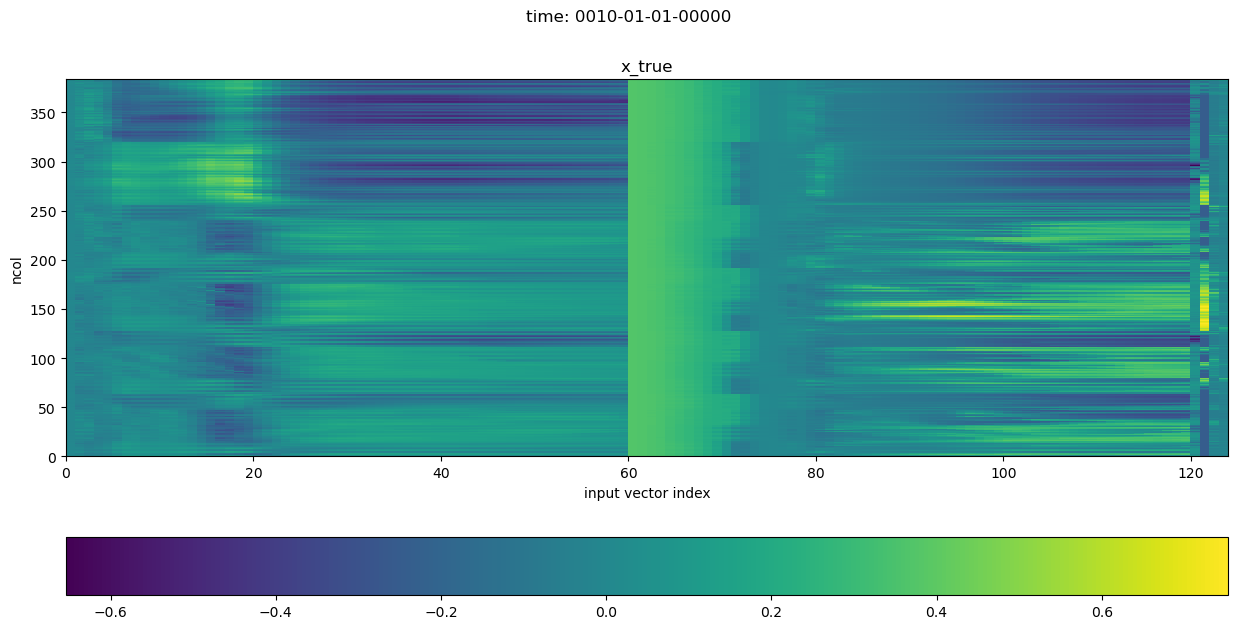

In [30]:
fig, ax = plt.subplots(ncols=1)
fig.suptitle(f'time: {f_mli[0].split(".")[-2]}')
h0 = ax.pcolor(x_true)#, vmin=-1, vmax=2)
ax.set_title('x_true')
ax.set_ylabel('ncol')
ax.set_xlabel('input vector index')
plt.colorbar(h0, orientation='horizontal')

fig.set_size_inches(15,7)

## Plot outputs 

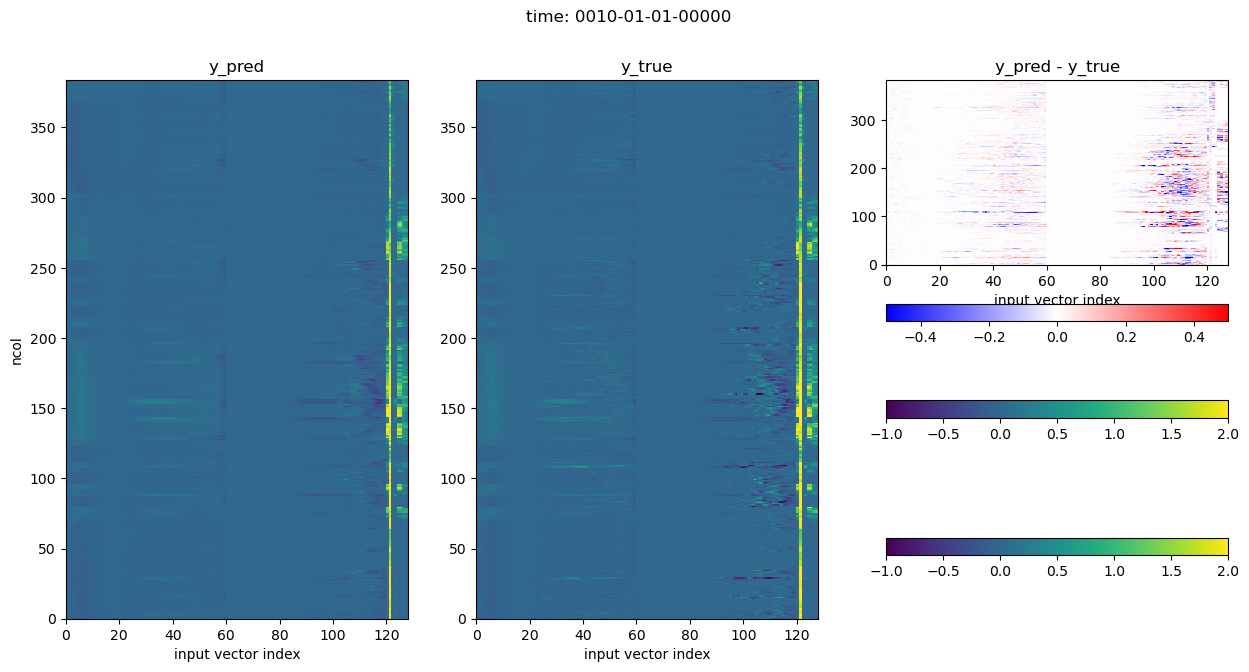

In [31]:
fig, ax_ = plt.subplots(ncols=3)
fig.suptitle(f'time: {f_mli[0].split(".")[-2]}')
ax = ax_[0]
h0 = ax.pcolor(y_pred, vmin=-1, vmax=2)
ax.set_title('y_pred')
ax.set_ylabel('ncol')
ax.set_xlabel('input vector index')
plt.colorbar(h0, orientation='horizontal')
ax = ax_[1]
h1 = ax.pcolor(y_true, vmin=-1, vmax=2)
ax.set_title('y_true')
ax.set_xlabel('input vector index')
plt.colorbar(h1, orientation='horizontal')
ax = ax_[2]
h2 = ax.pcolor(y_pred-y_true, vmin=-.5,vmax=.5,cmap='bwr')
ax.set_title('y_pred - y_true')
ax.set_xlabel('input vector index')
plt.colorbar(h2, orientation='horizontal')

fig.set_size_inches(15,7)

5 day mean and time series

In [33]:
f_mli = glob.glob(str(cfg['dataroot']/Path('E3SM-MMF.mli.0001-02-01-*')))
# dir_test_samples = '/global/homes/s/sungduk/work/LEAP/E3SM-MMF_baseline/test_data/0010-01'
dir_test_samples = 'test_data/0010-01'
f_mli = sorted(glob.glob(f'{dir_test_samples}/E3SM-MMF.mli.0010-01-0[12345]-*.nc'))
print(f'#files: {len(f_mli)}')
tds_test = load_nc_dir_with_generator_test(f_mli, latlim=[-10,10], lonlim=[160,200])

#files: 3


In [34]:
# creating numpy array defeats the purpose of tf Dataset pipeline,
# but, just doing it here for quick sanity check.

work = list(tds_test.as_numpy_iterator())
x_true = np.concatenate([ work[k][0] for k in range(len(work)) ])
y_true = np.concatenate([ work[k][1] for k in range(len(work)) ])
print(x_true.shape, y_true.shape)

load_model = keras.models.load_model("./saved_model/best_model_proto.h5")
y_pred = load_model(x_true)

2023-05-26 18:37:56.650758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


(24, 124) (24, 128)


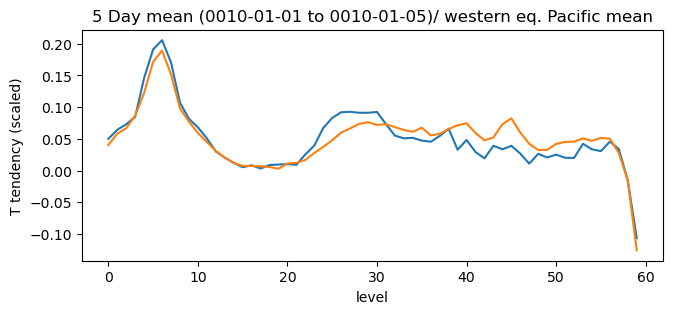

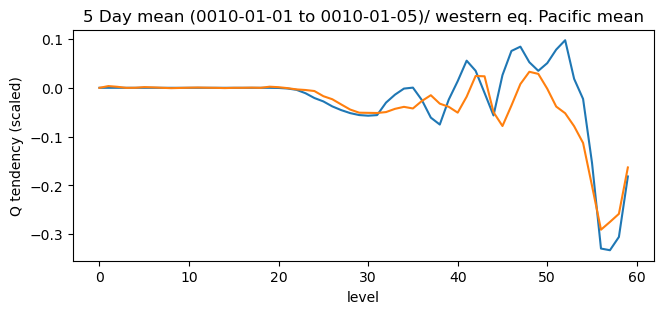

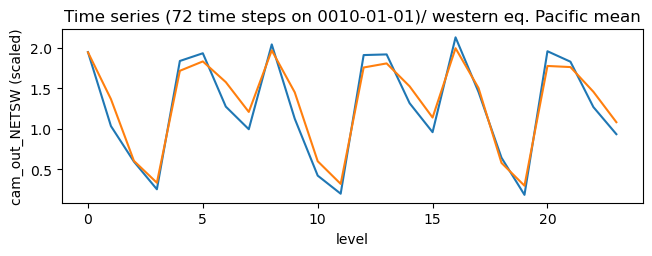

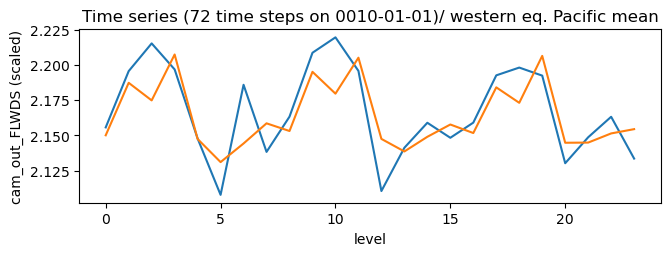

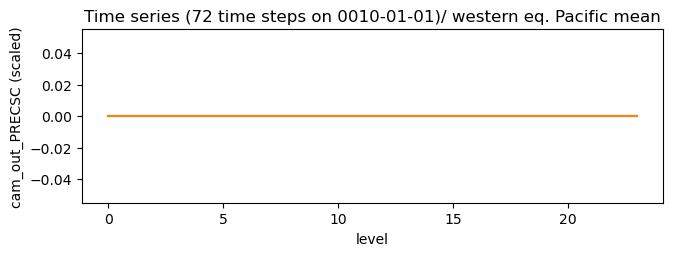

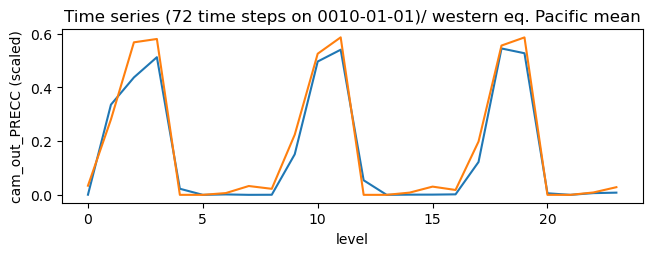

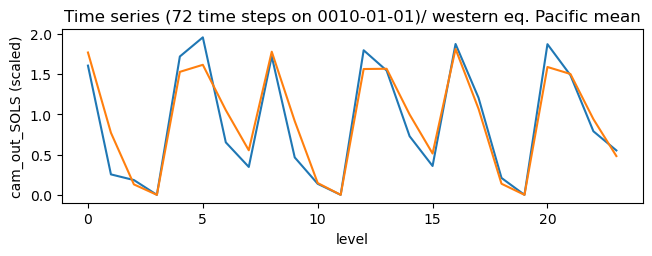

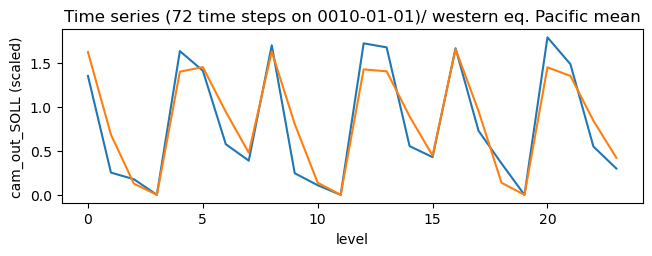

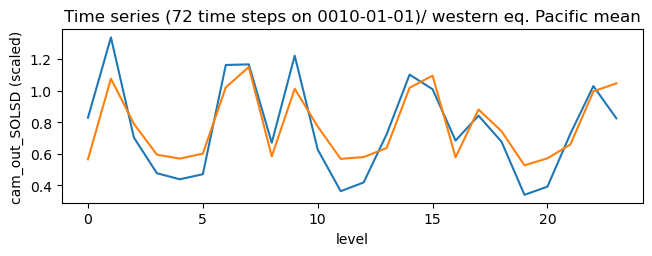

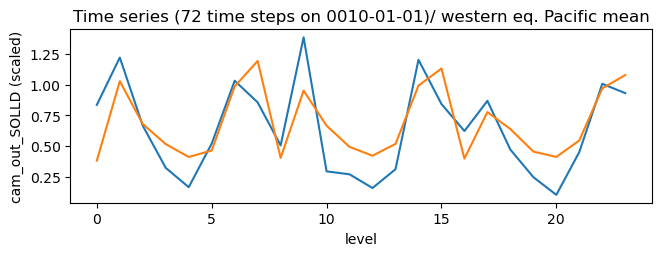

In [35]:
fig, ax = plt.subplots()
y_true_mean_T = np.mean(y_true[:,:60], axis=0)
y_pred_mean_T = np.mean(y_pred[:,:60], axis=0)
ax.plot(y_true_mean_T)
ax.plot(y_pred_mean_T)
ax.set_title('5 Day mean (0010-01-01 to 0010-01-05)/ western eq. Pacific mean')
ax.set_xlabel('level')
ax.set_ylabel('T tendency (scaled)')
fig.set_size_inches(7.5,3)

fig, ax = plt.subplots()
y_true_mean_Q = np.mean(y_true[:,60:120], axis=0)
y_pred_mean_Q = np.mean(y_pred[:,60:120], axis=0)
ax.plot(y_true_mean_Q)
ax.plot(y_pred_mean_Q)
ax.set_title('5 Day mean (0010-01-01 to 0010-01-05)/ western eq. Pacific mean')
ax.set_xlabel('level')
ax.set_ylabel('Q tendency (scaled)')
fig.set_size_inches(7.5,3)

for k, kvar in enumerate(vars_mlo[2:]):
    fig, ax = plt.subplots()
    
    y_true_surface_var = y_true[:,120+k][:72*1]
    y_pred_surface_var = y_pred[:,120+k][:72*1]
    
    ax.plot(y_true_surface_var)
    ax.plot(y_pred_surface_var)
    
    ax.set_title('Time series (72 time steps on 0010-01-01)/ western eq. Pacific mean')
    ax.set_xlabel('level')
    ax.set_ylabel(f'{kvar} (scaled)')
    fig.set_size_inches(7.5,2.25)